In [1]:
import sys
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

### Parameters

All parameters are from https://arxiv.org/abs/1701.07875 and https://arxiv.org/abs/1704.00028

In [2]:
# Root directory for dataset
# dataroot = "data/celeba" <-----gonna use MNIST instead since it has labels

num_epochs = 50

# Number of workers for dataloader
workers = 4

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
num_channel = 1 #<---change for MNIST

# Size of z latent vector (i.e. size of generator input)
z_dim = 100

# Size of feature maps in generator
gen_dim = 64

# Size of feature maps in discriminator
dis_dim = 64

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Learning rate for optimizers
lr = 1e-4 #<-----changed

# Beta1 hyperparam for Adam optimizers
# beta1 = 0.5  #<-----will use RMSprops instead

# discriminator iteration
dis_iter = 2

# # weight_clip
# weight_clip = 0.01  <-----remove

# regularization scaler for the gradient penalty
lambda_gp = 10

# needed for conditional gan <-----added
num_classes = 10

# used for generator labeling
embed_size = 100 #<---follow the paper

### Load dataset

Device:  cuda:0


/home/u1/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Min (should be -1):  tensor(-1.)
Max (should be 1):  tensor(1.)
X shape: (batch, C, H, W)   torch.Size([128, 1, 64, 64])
Label shape: (batch)   torch.Size([128])
Label unique values: (batch)   tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


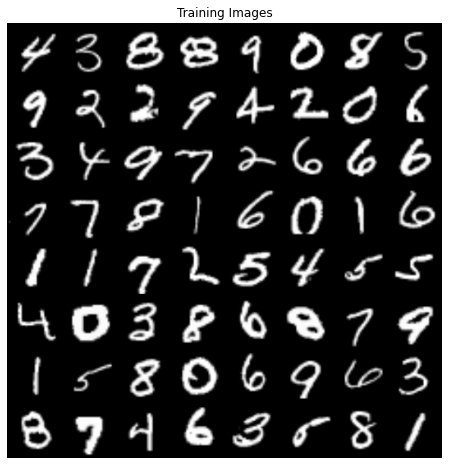

In [3]:
transform=transforms.Compose([
   transforms.Resize(image_size),
   transforms.CenterCrop(image_size),
   transforms.ToTensor(),  
   transforms.Normalize([0.5 for _ in range(num_channel)], [0.5 for _ in range(num_channel)]), 
])

dataset = dset.MNIST(root="data/", train=True,
                         transform=transform, download=True)

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

print("Device: ", device)

# Plot some training images
real_batch = next(iter(dataloader))

print("Min (should be -1): ", real_batch[0].min())
print("Max (should be 1): ", real_batch[0].max())
print("X shape: (batch, C, H, W)  ", real_batch[0].shape)
print("Label shape: (batch)  ", real_batch[1].shape)
print("Label unique values: (batch)  ", real_batch[1].unique())

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

### Weight Initialization

In [4]:
# custom weights initialization called on netG and netD
def weights_init(model):
    for m in model.modules(): #loop all layers in that model
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

### Generator

Follow the paper

In [5]:
# Generator Code
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.net = nn.Sequential(
            #Input: batch x z_dim x 1 x 1 (see definition of noise in below code)
            self._block(z_dim + embed_size, gen_dim * 16, 4, 1, 0),  #batch x 1024 x 4 x 4
            self._block(gen_dim * 16, gen_dim * 8, 4, 2, 1),  #batch x 512 x 8 x 8
            self._block(gen_dim * 8, gen_dim * 4, 4, 2, 1),  #batch x 256 x 16 x 16
            self._block(gen_dim * 4, gen_dim * 2, 4, 2, 1),  #batch x 128 x 32 x 32
            nn.ConvTranspose2d(
                gen_dim * 2, num_channel, kernel_size = 4, stride = 2, padding =1,  #did not use block because the last layer won't use batch norm or relu
            ),  #batch x 3 x 64 x 64
            nn.Tanh(), #squeeze output to [-1, 1]; easier to converge.  also will match to our normalize(0.5....) images  
        )
        self.embed = nn.Embedding(num_classes, embed_size)

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, out_channels,kernel_size,stride,padding,bias=False,  #batch norm does not require bias
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True) #in_place = True
        )
    
    def forward(self, x, labels):
        #Input: latent vector z: batch x z_dim x 1 x 1
        #in order to concat labels with the latent vector, we have to create two more dimensions of 1 by unsqueezing
        embedding = self.embed(labels).unsqueeze(2).unsqueeze(3)
        x = torch.cat([x, embedding], dim=1)
        return self.net(x)

Now, we can instantiate the generator and apply the ``weights_init`` function. Check out the printed model to see how the generator object is structured.

In [6]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (net): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(200, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inpla

### Discriminator

Follow the paper.

In [7]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.net = nn.Sequential(
            #no batch norm in the first layer 
            #Input: batch x num_channel x 64 x 64
            #<-----changed num_channel + 1 since we add the labels
            nn.Conv2d(
                num_channel + 1, dis_dim, kernel_size=4, stride=2, padding=1,
            ), #batch x 64 x 32 x 32
            nn.LeakyReLU(0.2, inplace=True),
            self._block(dis_dim, dis_dim * 2, 4, 2, 1), #batch x 128 x 16 x 16
            self._block(dis_dim * 2, dis_dim * 4, 4, 2, 1), #batch x 256 x 8 x 8
            self._block(dis_dim * 4, dis_dim * 8, 4, 2, 1), #batch x 512 x 4  x 4
            nn.Conv2d(dis_dim * 8, 1, kernel_size=4, stride=2, padding=0), #batch x 1 x 1 x 1 for classification
#             nn.Sigmoid(), #<------removed!
        )
        self.embed = nn.Embedding(num_classes, image_size*image_size)
        
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False,  #batch norm does not require bias
            ),
            nn.InstanceNorm2d(out_channels, affine=True), #<----changed here
            nn.LeakyReLU(0.2, True) #slope = 0.2, in_place = True
        )

    def forward(self, x, labels):
        #Label shape: batch, 
        #Label after embed shape: batch, image_size * image_size
        #reshape the labels further to be of shape (batch, 1, H, W) so we can concat
        #embedding shape:  batch, 1, image_size, image_size
        embedding = self.embed(labels).view(labels.shape[0], 1, image_size, image_size)
        x = torch.cat([x, embedding], dim = 1) #batch x (C + 1) x W x H
        return self.net(x)

Now, as with the generator, we can create the discriminator, apply the
``weights_init`` function, and print the model’s structure.

In [8]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (net): Sequential(
    (0): Conv2d(2, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (5): Conv2d(512, 1, kernel_

### Test

In [9]:
#let's write a test function to test whether our dis and gen are correctly coded
def test():
    batch, num_channels, H, W = 8, 1, 64, 64
    z_dim = 100
    x = torch.randn((batch, num_channels, H, W))
    labels = torch.randint(0, 9, (batch,), dtype=torch.float)
    labels = labels.long() #<----pytorch expect the labels to be long
    
    #testing discriminator
    netD = Discriminator(ngpu)
    netD.apply(weights_init)
    assert netD(x, labels).shape == (batch, 1, 1, 1) #output of dis should be only one value, ready for classification
    
    #testing generator
    netG = Generator(ngpu)
    netG.apply(weights_init)
    z = torch.randn((batch, z_dim, 1, 1))  #input to gen is (batch, 100, 1, 1)
    assert netG(z, labels).shape == (batch, num_channels, H, W) #output of gen is (batch, 3, 64, 64)

test()

### Loss Functions and Optimizers


In [10]:
# Initialize BCELoss function
# criterion = nn.BCELoss() <-----removed

# Create 64 latent vectors that we will use to visualize
# the progression of the generator
# fixed_noise = torch.randn(64, z_dim, 1, 1, device=device)  #<---no need since we need noise with labels, so we just gonna use noise to monitor progress

# Setup Adam optimizers for both G and D
# Use momentum of 0.5 following the paper
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.0, 0.9))  #<-----changed back! to RMSprop
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.0, 0.9))

### Enforces the gradient to be close to 1

In [11]:
def gradient_penalty(dis, labels, real, fake, device="cpu"): #<---add labels
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate dis scores
    mixed_scores = dis(interpolated_images, labels)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

### Training

-  **Loss_D** - discriminator loss calculated as the sum of losses for
   the all real and all fake batches ($log(D(x)) + log(D(G(z)))$).
-  **Loss_G** - generator loss calculated as $log(D(G(z)))$
-  **D(x)** - the average output (across the batch) of the discriminator
   for the all real batch. This should start close to 1 then
   theoretically converge to 0.5 when G gets better. 
-  **D(G(z))** - average discriminator outputs for the all fake batch.
   The first number is before D is updated and the second number is
   after D is updated. These numbers should start near 0 and converge to
   0.5 as G gets better. 

In [ ]:
# Training Loop
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, (real, labels) in enumerate(dataloader):  #<----take in labels
        real = real.to(device)
        labels = labels.long().to(device)
        cur_batch_size = real.shape[0]

        #Train D min - (E[dis(real)] - E[dis(fake)])
        for _ in range(dis_iter):
            output_real = netD(real, labels).view(-1)   
            noise = torch.randn(cur_batch_size, z_dim, 1, 1, device=device)
            fake = netG(noise, labels)
            output_fake = netD(fake, labels).view(-1)
            gp = gradient_penalty(netD, labels, real, fake, device=device)
            dis_loss = (
                -(torch.mean(output_real) - torch.mean(output_fake)) + lambda_gp * gp
            )
            netD.zero_grad()
            dis_loss.backward(retain_graph=True) #similar to detach()
            optimizerD.step()
                                
        # Train G: min -E[dis(gen_fake)]
        output = netD(fake, labels).view(-1)
        gen_loss = -torch.mean(output)        
        netG.zero_grad()
        gen_loss.backward()
        optimizerG.step()
        
        sys.stdout.write("\r" + str(epoch))
        
#         # Output training stats
#         if i % 50 == 0:
#             print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
#                   % (epoch, num_epochs, i, len(dataloader),
#                      errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(gen_loss.item())
        D_losses.append(dis_loss.item())
        
        # Check how the generator is doing by saving G's output on noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(noise, labels).detach().cpu() #<---send in noise instead to make sure the label matches
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

Starting Training Loop...
47

### Results

**Loss versus training iteration**

Below is a plot of D & G’s losses versus training iterations.

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Visualization of G’s progression**

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

**Real Images vs. Fake Images**

Finally, lets take a look at some real images and fake images side by side.

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()